# Анализ данных HeadHunter

---

Анализ вакансий "Аналитик" на сайте hh.ru по Санкт-Петербургу.
официальное API: https://dev.hh.ru/,

# создаём таблицу

In [ ]:
import requests  # для запросов на другие серверы, с ее помощью мы будем обращатсья к серверам head hunter
import json  # для работы с json-файлами
from time import sleep  # чтобы делать временные паузы в коде
from tqdm import tqdm
import pandas as pd

In [ ]:
URL = 'https://api.hh.ru/vacancies'  # URL для подключения к данным сайта Head Hunter 

data_list = [] 
sleep_interval = 0.5  # размер паузы, на каждой итерации скачивания данных 
N = 160  # количество страниц поисковой выдачи, данные с которых качаем

# скачиваем данные
for n in tqdm(range(N)):
  params = {#'text': "аналитик",  # параметр text, кладем сюда название вакансии 
          'professional_role': ["10", "150", "134", "164", "148", "156", "157", "163"], # коды для аналитиков из https://api.hh.ru/professional_roles
          #'search_field': "name",
          'area': 2,  # идентификатор города СПб
          'page': n,  # номер страницы поисковой выдачи по запросу из параметра text 
          'per_page': 10  # количество объектов на странице выдачи
         }

  req = requests.get(URL, params)
  data = json.loads(req.content.decode())
  data_list.append(data)
  sleep(sleep_interval)


100%|██████████| 160/160 [02:58<00:00,  1.11s/it]


In [ ]:
data.keys()

dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'alternate_url'])

In [ ]:
# всего предложений по данному запросу
data['found']

1548

In [ ]:
# всего страниц в поисковой выдаче
data['pages']

155

In [ ]:
# делаем таблицу из json по ключу items
df_raw = pd.json_normalize(data_list, record_path='items')
# смотрим её полностью
pd.set_option('display.max_columns', None)

In [ ]:
# формируем запрос, скачиваем данные и делаем список ссылок по которому пойдём собирать данные
req = requests.get(df_raw['url'][0])

data = json.loads(req.content.decode())

vacancy_urls = list(df_raw['url'])

In [ ]:
# скачиваем данные по списку ссылок
vacancies = []
sleep_interval = 0.5  # размер паузы, на каждой итерации скачивания данных 

for URL in tqdm(vacancy_urls):
    req = requests.get(URL)
    data = json.loads(req.content.decode())
    vacancies.append(data)
    sleep(sleep_interval)

100%|██████████| 1548/1548 [28:05<00:00,  1.09s/it]


In [ ]:
# обновим таблицу новыми данными
df_raw = pd.json_normalize(vacancies)

In [ ]:
# обработаем словарь навыков так, чтобы он стал списком
def get_list(x, name):
  list_of_skills = []
  try:
    for dict_skill in x:
      list_of_skills.append(dict_skill[name])
  except:
    pass
  return list_of_skills 

df_raw['key_skills'] = df_raw['key_skills'].apply(lambda x: get_list(x, 'name'))

In [ ]:
# разделим данные из ячейки с профессиональными ролями
def get_value(x, name):  
  try:
    return x[0].get(name)
  except:
    return ''

df_raw['professional_roles_id'] = df_raw['professional_roles'].apply(lambda x: get_value(x, 'id'))
df_raw['professional_roles_name'] = df_raw['professional_roles'].apply(lambda x: get_value(x, 'name'))

In [ ]:
# разделим данные из ячейки с языками
def get_value(x, name):  
  try:
    return x[0].get(name)
  except:
    return ''

def get_value_len(x, name):  
  try:
    return x.get(name)
  except:
    return ''

df_raw['languages_name'] = df_raw['languages'].apply(lambda x: get_value(x, 'name'))
df_raw['languages_lvl'] = df_raw['languages'].apply(lambda x: get_value(x, 'level'))
df_raw['languages_level'] = df_raw['languages_lvl'].apply(lambda x: get_value_len(x, 'name'))
df_raw['working_time_modes'] = df_raw['working_time_modes'].apply(lambda x: get_value(x, 'name'))
df_raw['working_time_intervals'] = df_raw['working_time_intervals'].apply(lambda x: get_value(x, 'name'))

In [ ]:
# удалим лишние столбцы
df_raw = df_raw[['id', 'name', 'description', 'key_skills','professional_roles_id', 'professional_roles_name','languages_name', 'languages_level',\
                 'salary.from', 'salary.to', 'salary.currency',	'salary.gross' ,\
                  'experience.name', 'schedule.name', 'employment.name', 'employer.id', 	'employer.name','address.city', \
                 'address.street', 	'address.building', 	'address.lat', 	'address.lng', 'address.metro.station_name', 'address.metro.lat', 	'address.metro.lng', 	\
                 'published_at', 'created_at', 'accept_temporary', 'accept_handicapped', 	'has_test', \
                 'working_time_modes', 'working_time_intervals', 'alternate_url'
                 ]]

# обработка данных

In [ ]:
# удалим дубликаты по id вакансии если они есть
df_raw = df_raw.drop_duplicates (subset=['id'])

<Axes: >

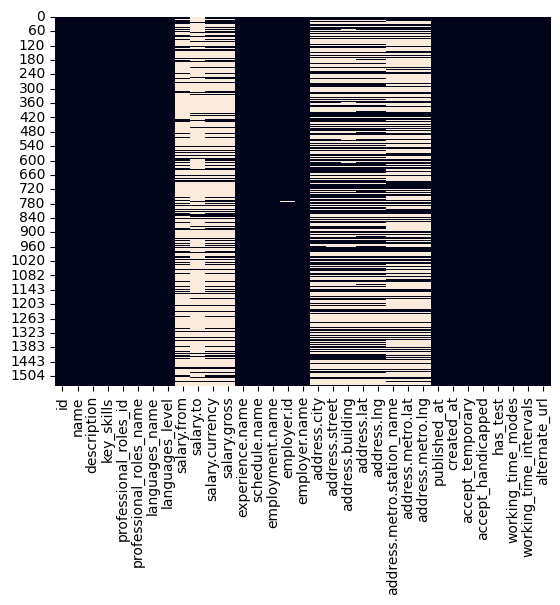

In [ ]:
# какие данные не заполнены
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_raw.isnull(),  cbar=False)#

In [ ]:
#смотрим о чём вообще данные наши
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544 entries, 0 to 1547
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          1544 non-null   object 
 1   name                        1544 non-null   object 
 2   description                 1544 non-null   object 
 3   key_skills                  1544 non-null   object 
 4   professional_roles_id       1544 non-null   object 
 5   professional_roles_name     1544 non-null   object 
 6   languages_name              1544 non-null   object 
 7   languages_level             1544 non-null   object 
 8   salary.from                 365 non-null    float64
 9   salary.to                   242 non-null    float64
 10  salary.currency             433 non-null    object 
 11  salary.gross                433 non-null    object 
 12  experience.name             1544 non-null   object 
 13  schedule.name               1544 

In [ ]:
# заменим нулевые значения
df_raw.fillna(0, inplace = True)

In [ ]:
# сменим тип данных для обработки
df_raw['id'] = df_raw['id'].astype('int32')
df_raw['professional_roles_id'] = df_raw['professional_roles_id'].astype('int16')
df_raw['salary.from'] = df_raw['salary.from'].astype('int32')
df_raw['salary.to'] = df_raw['salary.to'].astype('int32')
df_raw['employer.id'] = df_raw['employer.id'].astype('int32')
df_raw['published_at'] = df_raw['published_at'].astype('datetime64')
df_raw['created_at'] = df_raw['created_at'].astype('datetime64')
df_raw['salary.gross'] = df_raw['salary.gross'].astype('bool')

In [ ]:
# сохраним файл
df_raw.to_pickle('vacancies_spb.csv')

# анализ данных

## чистим зп от валюты и налогов

In [ ]:
# больше библиотек богам библиотек!
from collections import Counter
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving vacancies_spb.csv to vacancies_spb.csv


In [ ]:
df = pd.read_pickle('vacancies_spb.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# курсы евро и доллара на дату анализа
import requests
from bs4 import BeautifulSoup

url1 = 'https://www.cbr.ru/currency_base/daily/'
response = requests.get(url1)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', attrs={'class': 'data'})

rows = table.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    if len(cols) > 0:
        if cols[1].text == 'USD':
            usd = float(cols[4].text.replace(',', '.'))
        elif cols[1].text == 'EUR':
            eur = float(cols[4].text.replace(',', '.'))

print('Курс доллара:', usd)
print('Курс евро:', eur)

Курс доллара: 80.0366
Курс евро: 86.4964


In [ ]:
# сделаем функции для очистки зарплаты от валюты
def clean_to(row):
  if row['salary.currency'] == 'USD':
    x = row['salary.to']*usd
  elif row['salary.currency'] == 'EUR':
    x = row['salary.to']*eur   
  else: x = row['salary.to']
  return x

def clean_from(row):
  
  if row['salary.currency'] == 'USD':
    x = row['salary.from']*usd
  elif row['salary.currency'] == 'EUR':
    x = row['salary.from']*eur   
  else: x = row['salary.from']  
  return x

In [ ]:
# очистим столбец зарплаты от валюты
df['salary.from'] = df.apply(clean_from, axis=1)
df['salary.to'] = df.apply(clean_to, axis=1)

# очистим столбец зарплаты от налогов
df['salary.from'] = np.where(df['salary.gross'] == True, df['salary.from']*0.87, df['salary.from'])
df['salary.to'] = np.where(df['salary.gross'] == True, df['salary.to']*0.87, df['salary.to'])

# заменим тип данных
df['salary.from'] = df['salary.from'].astype('int32')
df['salary.to'] = df['salary.to'].astype('int32')


In [ ]:
# заполним пропуски в данных о зарплате от/до
df['salary.from'] = np.where((df['salary.from'] == 0) & (df['salary.to'] != 0), df['salary.to'], df['salary.from'])
df['salary.to'] = np.where((df['salary.from'] != 0) & (df['salary.to'] == 0), df['salary.from'], df['salary.to'])

## анализ количества вакансий

In [ ]:
# считаем каких аналитиков сколько нужно
vacancy_name_count = []
for i in df['professional_roles_name']:
  vacancy_name_count.append(i)

counter = Counter(vacancy_name_count).most_common()

# делаем из списка таблицу
names = pd.DataFrame(counter)
names.columns = ['Vacancy_name', 'count']
names['part'] = names['count'].apply(lambda x: round(100*x/names['count'].sum(),2))

In [ ]:
names

,Vacancy_name,count,part
0,Аналитик,796,51.55
1,Системный аналитик,194,12.56
2,Бизнес-аналитик,179,11.59
3,"Финансовый аналитик, инвестиционный аналитик",138,8.94
4,Маркетолог-аналитик,94,6.09
5,"BI-аналитик, аналитик данных",74,4.79
6,Руководитель отдела аналитики,35,2.27
7,Продуктовый аналитик,34,2.20


In [ ]:
# делаем новый столбец средний для подсчёта
df['salary'] = (df['salary.from']+df['salary.to'])/2
df['salary'] = df['salary'].astype('int32')

In [ ]:
# поиск средней зарплаты по направлениям аналитики
grouped_vacancy = df[df['salary.from'] > 0][df['salary.to'] > 0].groupby('professional_roles_name')
grouped_vacancy = grouped_vacancy.agg({'professional_roles_name': 'count', 'salary.from': ['min', 'max', 'mean', 'median'], 'salary.to': ['min', 'max', 'mean', 'median']}).\
  assign(mean_salary=lambda x: (x['salary.from']['mean'] + x['salary.to']['mean'])/2, median_salary=lambda x: x[['salary.from', 'salary.to']].median(axis=1)).\
  sort_values(by='mean_salary', ascending = False).astype('int32')

grouped_vacancy

<ipython-input-179-2a853bf40279>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



professional_roles_name  \
                                                               count   
professional_roles_name                                                
Руководитель отдела аналитики                                      4   
Продуктовый аналитик                                               6   
Системный аналитик                                                39   
BI-аналитик, аналитик данных                                      15   
Бизнес-аналитик                                                   36   
Аналитик                                                         245   
Финансовый аналитик, инвестиционный аналитик                      34   
Маркетолог-аналитик                                               54   

                                             salary.from                  \
                                                     min     max    mean   
professional_roles_name                                                    
Руководитель отдела аналитики                     160000  200000  183500   
Продуктовый аналитик                              100000  345985  170997   
Системный аналитик                                 30000  250000  116928   
BI-аналитик, аналитик данных                       26100  220980  112224   
Бизнес-аналитик                                    43500  200000   99418   
Аналитик                                           13050  400000   96176   
Финансовый аналитик, инвестиционный аналитик       40000  174000   87496   
Маркетолог-аналитик                                10000  130500   64749   

                                                     salary.to          \
                                              median       min     max   
professional_roles_name                                                  
Руководитель отдела аналитики                 187000    160000  200000   
Продуктовый аналитик                          125000    100000  345985   
Системный аналитик                            104400     30000  321900   
BI-аналитик, аналитик данных                  113100     26100  230000   
Бизнес-аналитик                               100000     56550  300000   
Аналитик                                       80000     15000  400000   
Финансовый аналитик, инвестиционный аналитик   76650     49000  348000   
Маркетолог-аналитик                            60900     20000  200000   

                                                             mean_salary  \
                                                mean  median               
professional_roles_name                                                    
Руководитель отдела аналитики                 183500  187000      183500   
Продуктовый аналитик                          192664  180000      181830   
Системный аналитик                            135106  130500      126017   
BI-аналитик, аналитик данных                  123370  120000      117797   
Бизнес-аналитик                               119530  102225      109474   
Аналитик                                      109152   95700      102664   
Финансовый аналитик, инвестиционный аналитик  104893   92850       96194   
Маркетолог-аналитик                            80373   70000       72561   

                                             median_salary  
                                                            
professional_roles_name                                     
Руководитель отдела аналитики                       185250  
Продуктовый аналитик                                175498  
Системный аналитик                                  123714  
BI-аналитик, аналитик данных                        116550  
Бизнес-аналитик                                     101112  
Аналитик                                             95938  
Финансовый аналитик, инвестиционный аналитик         90173  
Маркетолог-аналитик                                  67374

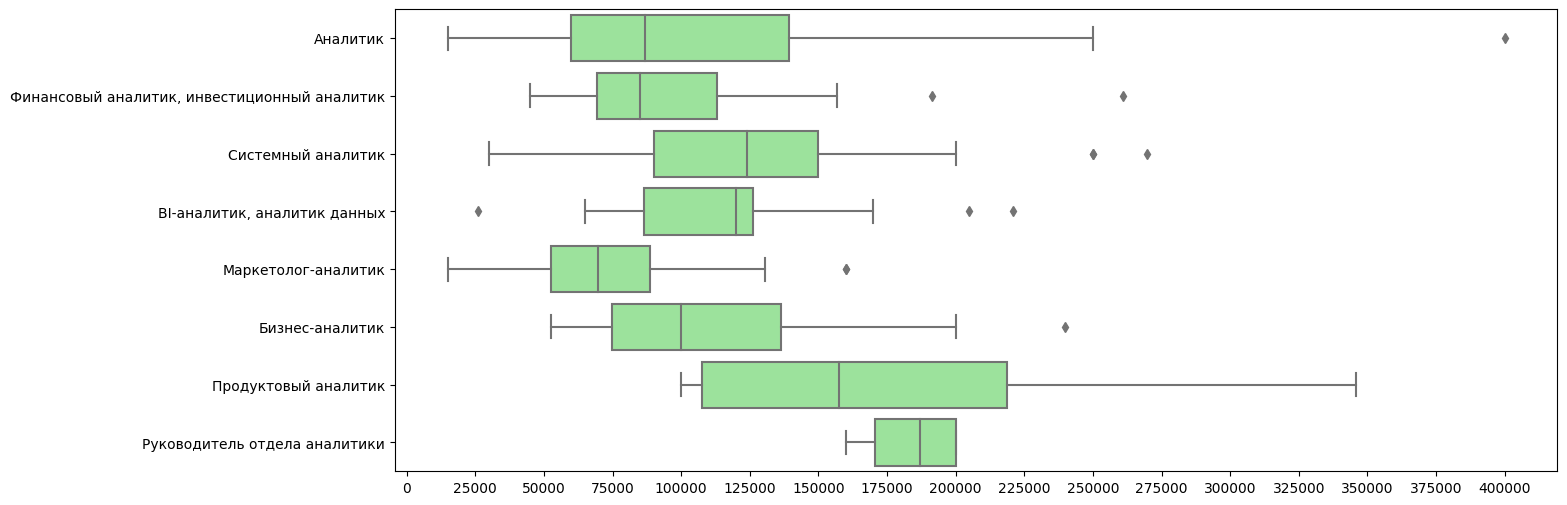

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(y='professional_roles_name', x='salary', data=df[df['salary']>0], color = 'lightgreen')
plt.xlabel('')
plt.xticks(np.arange(0, 425000, step=25000))

plt.ylabel('')
plt.show()

In [ ]:
# считаем каких аналитиков сколько нужно
name_count = []
for i in df['name']:
  name_count.append(i)

counter = Counter(name_count).most_common()

# делаем из списка таблицу
all_names = pd.DataFrame(counter)
all_names.columns = ['Vacancy_name', 'count']
all_names['part'] = all_names['count'].apply(lambda x: round(100*x/all_names['count'].sum(),2))


In [ ]:
#уникальных названий вакансий
len(all_names)

1104

In [ ]:
all_names[:10]

,Vacancy_name,count,part
0,Системный аналитик,84,5.44
1,Бизнес-аналитик,56,3.63
2,Аналитик,45,2.91
3,Аналитик 1С,45,2.91
4,Маркетолог-аналитик,21,1.36
5,Финансовый аналитик,21,1.36
6,Аналитик данных,12,0.78
7,Ведущий аналитик,10,0.65
8,Ведущий системный аналитик,9,0.58
9,Консультант-аналитик 1С,8,0.52


In [ ]:
# готовим таблицу для построения графика по видам аналитиков
all_names_top = all_names[:10]
allnamestop = all_names_top.merge(df, left_on='Vacancy_name', right_on='name', how='inner')[['Vacancy_name', 'salary']]

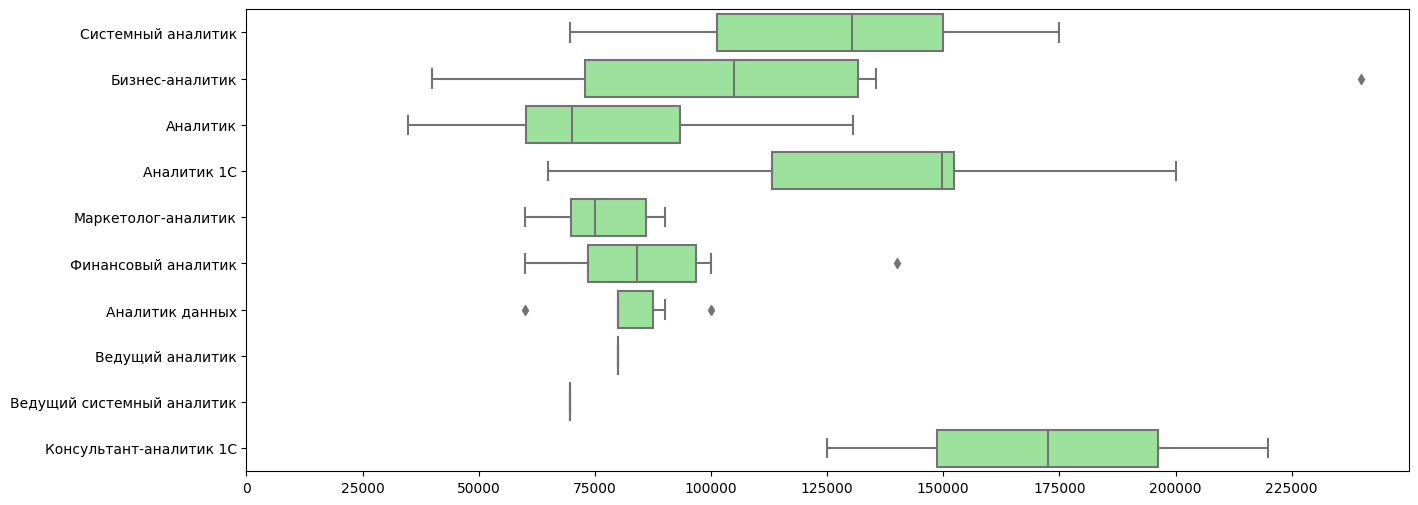

In [ ]:
# строим график по видам аналитиков
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(y='Vacancy_name', x='salary', data=allnamestop[allnamestop['salary']>0], color = 'lightgreen')
plt.xlabel('')
plt.xticks(np.arange(0, 250000, step=25000))
plt.ylabel('')
plt.show()

In [ ]:
# поиск средней зарплаты по направлениям аналитики
grouped_names = df[df['salary.from'] > 0][df['salary.to'] > 0].groupby('name')

grouped_names = grouped_names.agg({'name': 'count', 'salary.from': 'min', 'salary.to': 'max'}).\
  assign(mean_salary=lambda x: (x['salary.from'] + x['salary.to'])/2).sort_values(by='mean_salary', ascending = False).astype('int32')

grouped_names.columns = ['count', 'salary.from' ,	'salary.to' ,	'mean_salary']
grouped_names.reset_index(inplace= True)

<ipython-input-186-f3174579ce0d>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
grouped_names[grouped_names['count']>3]

,name,count,salary.from,salary.to,mean_salary
43,Бизнес-аналитик,12,40000,300000,170000
83,Системный аналитик,14,52200,220000,136100
94,Аналитик 1С,17,60000,200000,130000
127,Финансовый аналитик,8,60000,150000,105000
158,Маркетолог,6,60000,130500,95250
164,Аналитик данных,6,60000,120000,90000
170,Маркетолог-аналитик,8,50000,120000,85000
187,Аналитик,18,26100,130500,78300
198,Аналитик отдела продаж,7,45000,100000,72500


In [ ]:
mask = grouped_names["name"].str.contains('Senior|главный|ведущий|Lead', case=False)
res = grouped_names.loc[mask]
res

,name,count,salary.from,salary.to,mean_salary
0,Tech Lead Python,1,400000,400000,400000
1,Senior Product Analyst,1,345985,345985,345985
2,Системный аналитик (Senior),3,200000,321900,260950
3,Senior/Team Lead Data Scientist,1,250000,250000,250000
6,Ведущий системный аналитик (интеграция),1,250000,250000,250000
9,Ведущий бизнес-аналитик 1С по регламентированн...,1,200000,270000,235000
16,Ведущий консультант-аналитик 1С:ERP по направл...,1,200000,200000,200000
18,Senior Data Аналитик (маркетинг),1,200000,200000,200000
20,Ведущий аналитик 1С (ЗУП),1,200000,200000,200000
22,Middle / Senior Systems Analyst,1,200000,200000,200000


In [ ]:
#grouped_names.to_csv('vac.csv', index= False )

## анализ навыков

In [ ]:
#наиболее часто встречающиеся навыки 
skill_count = []
try:
  for i in range(len(df['key_skills'])):
    for j in df['key_skills'][i]:
      skill_count.append(j)
except:
  pass
counter_skills = Counter(skill_count).most_common()
counter_skills

# делаем из списка таблицу
skills = pd.DataFrame(counter_skills)
skills.columns = ['Skill_names', 'count']
skills['part'] = skills['count'].apply(lambda x: round(100*x/skills['count'].sum(),2))

In [ ]:
skills.to_csv('skilllls.csv')

In [ ]:
skills_10 = skills[:15]
skills[:15]

,Skill_names,count,part
0,SQL,211,4.20
1,Аналитическое мышление,149,2.97
2,Бизнес-анализ,130,2.59
3,BPMN,117,2.33
4,Анализ данных,110,2.19
5,UML,86,1.71
6,Python,83,1.65
7,Системный анализ,77,1.53
8,Работа с большим объемом информации,69,1.37
9,Аналитика,66,1.31


In [ ]:
len(skills)

1026

In [ ]:
skills[skills['Skill_names'].str.contains('тест', case=False)]

,Skill_names,count,part
71,A/B тесты,13,0.26
206,Тестирование,4,0.08
335,Проведение тестирований,3,0.06
773,Тестирование пользовательского интерфейса,1,0.02
867,Функциональное тестирование,1,0.02
909,AB-тестирование,1,0.02


In [ ]:
skills[skills['Skill_names'].str.contains('GOOGLE', case=False)]
# total 14

,Skill_names,count,part
50,Google Analytics,18,0.36
102,Google таблицы,9,0.18
195,Google Data Studio,4,0.08
197,Google Sheets,4,0.08
251,Google Tag Manager,4,0.08
261,Google Docs,3,0.06
537,Google Таблицы,1,0.02
586,Google Sheet,1,0.02
792,Google Data Studiо,1,0.02
811,Google Ads,1,0.02


In [ ]:
skills[skills['Skill_names'].str.contains('yandex|datalens|яндекс|lens', case=False)]

,Skill_names,count,part
53,Яндекс.Метрика,17,0.34
242,Яндекс.Директ,4,0.08
375,Yandex Direct,2,0.04
517,Яндекс.Трекер,1,0.02
610,DataLens,1,0.02


In [ ]:
skills[skills['Skill_names'].str.contains('BI', case=False)]
# total 104 pcs

,Skill_names,count,part
12,Power BI,59,1.17
61,PowerBI,15,0.30
65,BI,15,0.30
75,MS Power BI,13,0.26
122,Big Data,7,0.14
317,RabbitMQ,3,0.06
350,Power-BI,2,0.04
429,Bitrix,2,0.04
430,Bitrix24,2,0.04
521,POWER BI,1,0.02


In [ ]:
skills[skills['Skill_names'].str.contains('excel', case=False)]
#total 111

,Skill_names,count,part
13,MS Excel,57,1.13
21,Excel,39,0.78
169,Работа в Excel,5,0.10
236,Продвинутый пользователь MS Excel,4,0.08
280,Знание Excel,3,0.06
337,MC Excel,3,0.06
472,"MS Office (Word, Excel, PowerPoint)",1,0.02
696,"MS Office (Excel, Power Point); Методы и техно...",1,0.02
837,"Знание Word, Excel",1,0.02
843,"уверенное владение ПК, знание 1С, Word, Excel",1,0.02


In [ ]:
skills[skills['Skill_names'].str.contains('английский', case=False)]

,Skill_names,count,part
19,Английский язык,45,0.90
589,Английский язык (Upper-Intermediate),1,0.02
658,Английский язык (Intermediate),1,0.02
840,Разговорный английский,1,0.02


In [ ]:
#наиболее часто встречающиеся языки
lang_count = []
try:
  for i in range(len(df['languages_name'])):
    lang_count.append(df['languages_name'][i])
except:
  pass

counter_langs = Counter(lang_count).most_common()
counter_langs
# делаем из списка таблицу
langs = pd.DataFrame(counter_langs)
langs.columns = ['Lang_names', 'count']

In [ ]:
langs

,Lang_names,count
0,,982
1,Английский,77
2,Французский,1


In [ ]:
#наиболее часто встречающиеся языки
lang_count = []
try:
  for i in range(len(df['languages_level'])):
    lang_count.append(df['languages_level'][i])
except:
  pass
  
counter_langslvl = Counter(lang_count).most_common()

# делаем из списка таблицу
langs = pd.DataFrame(counter_langs)
langs.columns = ['Lang_lvl', 'count']

counter_langslvl

[('', 982),
 ('B1 — Средний', 31),
 ('B2 — Средне-продвинутый', 25),
 ('A2 — Элементарный', 10),
 ('A1 — Начальный', 10),
 ('C2 — В совершенстве', 2)]

## размер зп

In [ ]:
df['salary.currency'].unique()

array([0, 'RUR', 'USD', 'EUR'], dtype=object)

In [ ]:
# а вот сколько вакансий с оплатой в инвалюте, штук
len(df[(~(df['salary.currency']=='RUR')&(~(df['salary.currency']==0)))])

3

In [ ]:
df['salary.from'][df['salary.from']>0].describe()

count       433.000000
mean      96113.579677
std       52267.725030
min       10000.000000
25%       60000.000000
50%       80000.000000
75%      121800.000000
max      400000.000000
Name: salary.from, dtype: float64

In [ ]:
df['salary.to'][df['salary.to']>0].describe()

count       433.000000
mean     110765.960739
std       58673.014246
min       15000.000000
25%       69600.000000
50%      100000.000000
75%      150000.000000
max      400000.000000
Name: salary.to, dtype: float64

In [ ]:
# очень не любят работадатели указывать зп, вот сколько их из всех указали размер зп. в %
# использую для полсчёта валюту тк это обязательный пункт при указанной начальной или конечной зп, а если зп не указана - то и валюты нет
round(100*df[~(df['salary.currency']==0)]['salary.currency'].count()/df['id'].count(), 2)

28.04

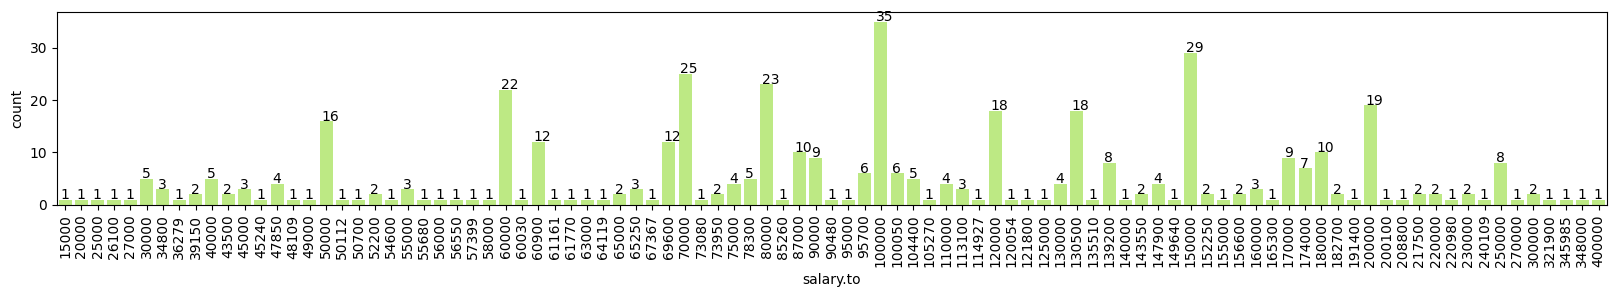

In [ ]:
plt.figure(figsize=(20,2.5))
a = sns.countplot(x='salary.to', data=df[df['salary.to'] > 0], color = (191/255, 250/255, 115/255, 1))
plt.xticks(rotation=90)
for p in a.patches:
     a.annotate(str(int(p.get_height())), (p.get_x()+0.1, p.get_height()+0.1))

plt.show()

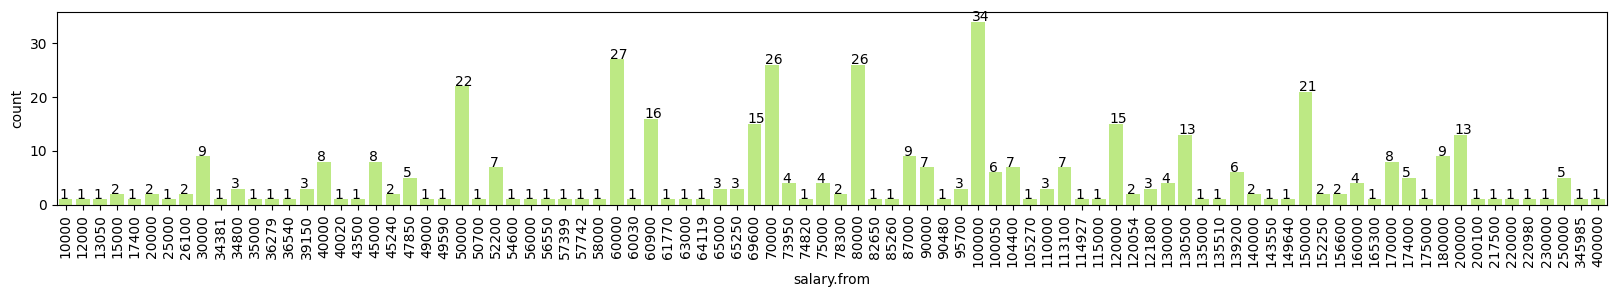

In [ ]:
# 
plt.figure(figsize=(20,2.5))
a = sns.countplot(x='salary.from', data=df[df['salary.from'] > 0], color = (191/255, 250/255, 115/255, 1))
plt.xticks(rotation=90)
for p in a.patches:
     a.annotate(str(int(p.get_height())), (p.get_x()+0.02, p.get_height()+0.1))

plt.show()

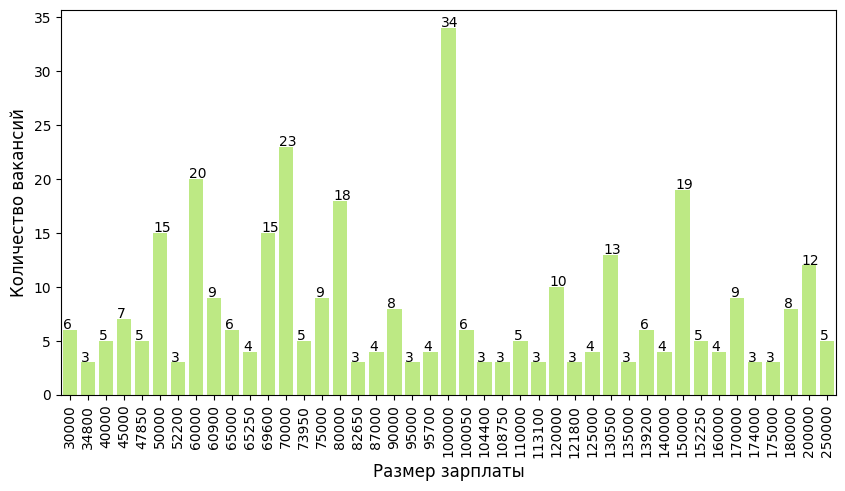

In [ ]:
# данные по средней зп
plt.figure(figsize=(10,5))
salary_counts = df[df['salary']>0]['salary'].value_counts()
data = df[df['salary'].isin(salary_counts.index[salary_counts > 2])]
a = sns.countplot(x='salary', data=data, color = (191/255, 250/255, 115/255, 1))
plt.xticks(rotation=90)
for p in a.patches:
     a.annotate(str(int(p.get_height())), (p.get_x()+0.01, p.get_height()+0.1))

plt.xlabel('Размер зарплаты', fontsize=12)
plt.ylabel('Количество вакансий', fontsize=12)
plt.show()
 

## по видам занятости

In [ ]:
employment = df.groupby('employment.name')[['employment.name']].count()  # 97,22% всех вакансий

employment['part'] = employment['employment.name']/employment['employment.name'].sum()
employment

,employment.name,part
employment.name,,
Полная занятость,1501,0.972150
Проектная работа,6,0.003886
Стажировка,21,0.013601
Частичная занятость,16,0.010363


In [ ]:
# средняя зп в зависимости от занятости
grouped_d = df[df['salary.from'] > 0][df['salary.to'] > 0].groupby('employment.name')
grouped_d.agg({'employment.name': 'count', 'salary.from': 'mean', 'salary.to': 'mean'}).sort_values(by='salary.to', ascending=False)

<ipython-input-213-c17e134e44f7>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,employment.name,salary.from,salary.to
employment.name,,,
Проектная работа,2,59800.000000,122850.000000
Полная занятость,415,98149.520482,112928.751807
Частичная занятость,7,49357.142857,58642.857143
Стажировка,9,46669.888889,48892.111111


In [ ]:
methods = df.groupby('schedule.name')[['schedule.name']].count()
methods.rename(columns = {'schedule.name' : 'counts'}, inplace = True)
methods.reset_index(inplace= True)
methods['part'] = round(100*methods['counts']/(methods['counts'].sum()),2)
methods

,schedule.name,counts,part
0,Гибкий график,51,3.30
1,Полный день,1226,79.40
2,Сменный график,1,0.06
3,Удаленная работа,266,17.23


In [ ]:
# средняя зп в зависимости от опыта метода работы
grouped_data_small = df[df['salary.from'] > 0][df['salary.to'] > 0].groupby('schedule.name')
grouped_data_small.agg({'schedule.name': 'count', 'salary.from': 'mean', 'salary.to': 'mean'}).sort_values(by='salary.to', ascending=False)

<ipython-input-215-e774ced407f3>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,schedule.name,salary.from,salary.to
schedule.name,,,
Удаленная работа,110,108270.809091,128770.400000
Гибкий график,14,102657.142857,125335.714286
Полный день,309,91489.291262,103696.495146


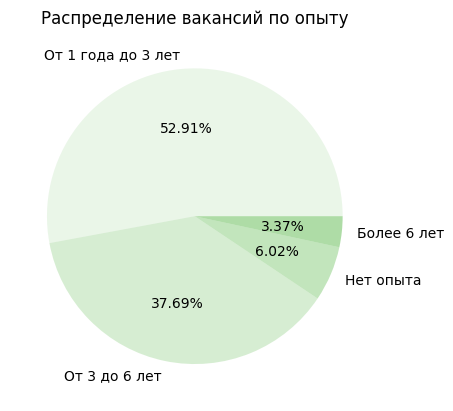

In [ ]:
experience = df['experience.name'].value_counts()

colors = [(54/255, 169/255, 34/255, x/10) for x in range(1, len(experience)+1)]
plt.pie(experience.values, labels=experience.index, autopct='%1.2f%%', colors=colors)
plt.title('Распределение вакансий по опыту')
plt.show()

In [ ]:
df.groupby('experience.name')[['experience.name']].count()

,experience.name
experience.name,
Более 6 лет,52
Нет опыта,93
От 1 года до 3 лет,817
От 3 до 6 лет,582


In [ ]:
# средняя зп в зависимости от опыта работы
grouped_data_small = df[df['salary.from'] > 0][df['salary.to'] > 0].groupby('experience.name')
grouped_data_small.agg({'experience.name': 'count', 'salary.from': 'mean', 'salary.to': 'mean'}).sort_values(by='salary.to', ascending=False)

<ipython-input-218-c5eb4681a237>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,experience.name,salary.from,salary.to
experience.name,,,
Более 6 лет,13,148696.153846,173903.846154
От 3 до 6 лет,128,125404.273438,141710.015625
От 1 года до 3 лет,251,85789.653386,99799.916335
Нет опыта,41,51199.512195,61274.390244


In [ ]:
# найдём работодателей с максимальным количеством вакансий
empl = df.groupby('employer.name')[['employer.name']].count().reset_index(names=['employees']).sort_values(by='employer.name', ascending=False)
empl.rename(columns = {'employer.name' : 'Vacations', 'employees' : 'employer.name'}, inplace = True)

# сделаем новую таблицу только из 10 самых активно набирающих 
emp = empl[:10]
emp

,employer.name,Vacations
322,Газпром нефть,98
607,СБЕР,26
315,Газпром ЦПС,24
91,IBS,20
363,Деловые Линии,18
552,Первый Бит,17
274,Банк Санкт-Петербург,15
456,"Лента, федеральная розничная сеть",14
502,Мэлон Фэшн Груп,13
685,Технологии Доверия,11


In [ ]:
# добавим данные из прошлой таблицы чтобы больше деталей по опыту взять
table = emp.merge(df, left_on='employer.name', right_on='employer.name', how='inner')

In [ ]:
amount_data = pd.pivot_table(table,
               index=["employer.name"],
               columns=["experience.name"],
               values=["employer.id"],
               aggfunc='count',
               fill_value=0,
               margins= True , margins_name='Итого',
               sort = True
               )
# убираем верхнюю строку от сводной таблицы
amount_data.columns = amount_data.columns.droplevel()
# сортируем
amount_data.sort_values(by='Итого', ascending=False)

experience.name,Более 6 лет,Нет опыта,От 1 года до 3 лет,От 3 до 6 лет,Итого
employer.name,,,,,
Итого,6,7,150,93,256
Газпром нефть,1,3,59,35,98
СБЕР,0,1,20,5,26
Газпром ЦПС,0,0,4,20,24
IBS,1,0,4,15,20
Деловые Линии,0,0,13,5,18
Первый Бит,0,1,13,3,17
Банк Санкт-Петербург,0,1,13,1,15
"Лента, федеральная розничная сеть",0,0,9,5,14


In [ ]:
# самые большие зарплаты вот тут. 
sal = df.groupby('employer.name').mean().reset_index(names=['employees']).sort_values(by='salary.to', ascending=False)
sal[['employees','salary.to']][:10]

<ipython-input-222-63cd150e3d5a>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,employees,salary.to
18,AppMagic,345985.0
215,АЙТИ.СПЕЙС,300000.0
14,AXELSOFT,250000.0
2,4people,250000.0
300,Волкрафт,250000.0
640,Сеть Партнерств,250000.0
52,Defa Group,250000.0
180,Sidus Gates IT Services L.L.C,240109.0
31,BestDoctor,240000.0
57,Diamond Personnel R&C,229100.0


In [ ]:
# найдём какие компании платят больше всего
salaries = pd.pivot_table(df,
               index=["employer.name"],
               columns=["experience.name"],
               values=["salary.from"],
               aggfunc='mean',
               fill_value=0,
               margins= True , margins_name='Итого'
               )
# убираем верхнюю строку от сводной таблицы
salaries.columns = salaries.columns.droplevel()
salaries.reset_index(inplace= True)

salaries['От 1 года до 3 лет'] = salaries['От 1 года до 3 лет'].astype('int32')
salaries['От 3 до 6 лет'] = salaries['От 3 до 6 лет'].astype('int32')
#удалим все нулевые строки
salaries = salaries.loc[salaries['Итого'] != 0]

In [ ]:
salaries.iloc[:, 0:2].sort_values(by='Более 6 лет', ascending=False)[:10]

experience.name,employer.name,Более 6 лет
705,Фаст Софт,400000.0
640,Сеть Партнерств,250000.0
31,BestDoctor,230000.0
57,Diamond Personnel R&C,217500.0
385,ИСТ,175000.0
498,Морион,121800.0
635,Севзапнефтепродукт,100000.0
374,Диполь,100000.0
365,Делориан,80000.0
720,ЦНИИ РТК,75000.0


In [ ]:
salaries.iloc[:, [0,2]].sort_values(by='Нет опыта', ascending=False)[:10]

experience.name,employer.name,Нет опыта
177,SearchInform,120000.0
292,Вайтлист,115250.0
688,Тинькофф,104400.0
213,А-Контракт,75000.0
737,Эй Джи Ти,70000.0
248,Альянс ТМ,69600.0
596,"Роскар, птицефабрика",69600.0
10,ARC Strategy,69600.0
564,Пластэк,63000.0
218,"АЛИДИ, Группа компаний",60000.0


In [ ]:
salaries.iloc[:, [0,3]].sort_values(by='От 1 года до 3 лет', ascending=False)[:10]

experience.name,employer.name,От 1 года до 3 лет
497,Монополия,220980
33,Business Mentor,200000
579,РАУ АйТи,200000
733,Штурм,200000
52,Defa Group,180000
0,1C-Рарус,170000
122,Loyalty Labs,170000
281,Булочные Ф.Вольчека,170000
97,ITLand,160000
688,Тинькофф,156600


In [ ]:
salaries.iloc[:, [0,4]].sort_values(by='От 3 до 6 лет', ascending=False)[:10]

experience.name,employer.name,От 3 до 6 лет
18,AppMagic,345985
2,4people,250000
300,Волкрафт,250000
31,BestDoctor,250000
71,Filtero,220000
463,Лоция,200000
472,МСУ-1,200000
598,Россети Центр,200000
486,МедиаСофт,200000
533,Онлайн-школа Фоксфорд,200000


In [ ]:
skills_10

,Skill_names,count,part
0,SQL,211,4.20
1,Аналитическое мышление,149,2.97
2,Бизнес-анализ,130,2.59
3,BPMN,117,2.33
4,Анализ данных,110,2.19
5,UML,86,1.71
6,Python,83,1.65
7,Системный анализ,77,1.53
8,Работа с большим объемом информации,69,1.37
9,Аналитика,66,1.31


In [ ]:
def get_skill(x, skill):
  if skill in x:
    return 1
  else: 
    return 0

In [ ]:
# создание столбцов has_skill в таблице df
for skill in skills_10['Skill_names']:
    df['has_'+skill] = df['key_skills'].apply(lambda x: get_skill(x, skill))

In [ ]:
salary_to = pd.DataFrame()
salary_from = pd.DataFrame()

# создание столбцов salary.from и salary.to в таблице skills
for skill in skills_10['Skill_names']:
    a = df[(df['salary.to']>0)].groupby('has_'+skill).mean()[['salary.to']]
    a.columns = [skill]
    a = a.T
    a.reset_index(inplace=True)
    salary_to = pd.concat([salary_to, a], ignore_index=True)
        
    b = df[(df['salary.from']>0)].groupby('has_'+skill).mean()[['salary.from']]
    b.columns = [skill]
    b = b.T
    b.reset_index(inplace=True)
    salary_from = pd.concat([salary_from, b], ignore_index=True)

# объединим обе таблицы в одну
salary_from.columns = ['Skill', 'no_skill_salary_from', 'has_skill_salary_from']
salary_to.columns = ['Skill', 'no_skill_salary_to', 'has_skill_salary_to']
salary_end = salary_from

# заменим тип днных чтобы округлить итог
salary_end['no_skill_salary_to'] = salary_to['no_skill_salary_to'].astype('int32')
salary_end['has_skill_salary_to'] = salary_to['has_skill_salary_to'].astype('int32')
salary_end['no_skill_salary_from'] = salary_end['no_skill_salary_from'].astype('int32')
salary_end['has_skill_salary_from'] = salary_end['has_skill_salary_to'].astype('int32')
# меняем местами столбцы
salary_end = salary_end[['Skill', 'no_skill_salary_from', 'no_skill_salary_to', 'has_skill_salary_from', 'has_skill_salary_to']]

In [ ]:
salary_end.to_csv('skills.csv')

In [ ]:
# выведем среднюю зп между от/до и узнаем как зависит зп от наличия навыков
salary_end.insert ( len(salary_end.columns ), 'no_skill_salary',  (salary_end['no_skill_salary_to'] + salary_end['no_skill_salary_from'])/2)
salary_end.insert ( len(salary_end.columns ), 'has_skill_salary',  (salary_end['has_skill_salary_from'] + salary_end['has_skill_salary_to'])/2)
salary_end['no_skill_salary']=salary_end['no_skill_salary'].astype('int32')
salary_end['has_skill_salary']=salary_end['has_skill_salary'].astype('int32')
salary_end.insert ( len(salary_end.columns ), 'Difference', salary_end['has_skill_salary'] - salary_end['no_skill_salary'])
salary_end.insert ( len(salary_end.columns ), 'Difference_%', round(100*salary_end['Difference']/salary_end['has_skill_salary'], 2))

salary_end

<ipython-input-233-0bb5d577945a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-233-0bb5d577945a>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Skill,no_skill_salary_from,no_skill_salary_to,has_skill_salary_from,has_skill_salary_to,no_skill_salary,has_skill_salary,Difference,Difference_%
0,SQL,93391,108767,126431,126431,101079,126431,25352,20.05
1,Аналитическое мышление,98390,113174,99628,99628,105782,99628,-6154,-6.18
2,Бизнес-анализ,92692,107396,136000,136000,100044,136000,35956,26.44
3,BPMN,93561,108551,144059,144059,101056,144059,43003,29.85
4,Анализ данных,97850,111982,98116,98116,104916,98116,-6800,-6.93
5,UML,94289,109107,141750,141750,101698,141750,40052,28.26
6,Python,95557,110400,119709,119709,102978,119709,16731,13.98
7,Системный анализ,93679,108677,143457,143457,101178,143457,42279,29.47
8,Работа с большим объемом информации,98809,113545,84189,84189,106177,84189,-21988,-26.12
9,Аналитика,96399,110734,111224,111224,103566,111224,7658,6.89


In [ ]:
len(df[df['has_test'] == True])

63

In [ ]:
len(df[df['accept_handicapped'] == True])

43

In [ ]:
# вакансии с релокацией. втч в СПБ и ЛО
reloc = df[df["description"].str.contains('Релокация|релокации|релокацию|переезд', case=False)]

In [ ]:
len(reloc)

0.03626943005181347

In [ ]:
df['published_at'].describe()

<ipython-input-238-228d001b7300>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                    1544
unique                   1498
top       2023-05-15 09:15:22
freq                        5
first     2023-04-15 14:45:21
last      2023-05-15 15:20:32
Name: published_at, dtype: object

In [ ]:
#вынесем дату из даты временни в столбце чтобы поискать зависимости в публицациях по времени
df['published_at'] = pd.to_datetime(df['published_at']). dt.date


## Карта

In [ ]:
# больше всего у метро вакансий
df1 = df[df['address.metro.station_name']!= 0]
r = df1.groupby(['address.metro.station_name'])[['id']].count().sort_values(by='id', ascending=False)
r[:10]

,id
address.metro.station_name,
Лесная,29
Василеостровская,28
Новочеркасская,28
Звёздная,24
Чернышевская,22
Московские ворота,22
Петроградская,22
Площадь Александра Невского 1,21
Горьковская,21


In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(df, # ваш датафрейм
                        lat='address.lat', # колонка с широтой
                        lon='address.lng', # колонка с долготой
                        zoom=10, # увеличение
                        height=800, # высота картинки 
                        width=1200, # ширина картинки
                        center=dict(lat=59.939095, lon=30.315868)) # центрирование на Санкт-Петербурге
fig.update_layout(mapbox_style="open-street-map")

# добавляем heatmap
fig.add_heatmap(x=df['address.lat'], y=df['address.lng'])

fig.show()

In [ ]:
#!pip install folium

In [ ]:
#!pip install geopandas

In [ ]:
#Тепловая карта
from folium.plugins import HeatMap
import folium

#Создание карты СПб
hmap = folium.Map(location=[59.95, 30.15], zoom_start=11,
              height=800,
              width=1200  )

#Слой для вакансий
people = folium.FeatureGroup(name = 'Количество вакансий СПб')


hm = HeatMap( list(zip(df['address.lat'].values, df['address.lng'].values, df['id'])), 
              min_opacity = 0.6,
              max_val = df['id'].max(),
              radius = 15, 
              blur = 25, 
              max_zoom = 1                
              )

people.add_child(hm)

# #Маркеры с адресами метро
# filial = df[df['address.metro.station_name'] != 0]
# filial_markers = folium.FeatureGroup(name = 'Метро')

# for index, row in filial.iterrows():
#     folium.Marker(
#         location = [row['address.lat'], row['address.lng']],
#         popup = row['address.metro.station_name'],
#         icon = folium.Icon(color='blue')
#         ).add_to(filial_markers)

      
#Добавляем слои на карту
hmap.add_child(people)
#hmap.add_child(filial_markers)

#Добавляем контроль слоев
folium.LayerControl(collapsed=False).add_to(hmap)

hmap

<ipython-input-244-699b59c3a7ef>:14: UserWarning:

The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.



# Новый раздел

In [ ]:
# создам таблицу для выгрузки в BI
df_end=df
df_end.drop(columns = ['key_skills', 'description'],axis = 1, inplace=True) 
df_end.to_csv('vacancies_spb_end.csv')